In [1]:
import librosa

In [2]:
IEMOCAP_PATH = "/home/tk/repos/erc/Datasets/IEMOCAP"

from glob import glob
import os

dias = {DATASET: sorted(os.listdir(os.path.join(IEMOCAP_PATH, f'raw-videos/{DATASET}/'))) 
            for DATASET in ['train', 'val', 'test']}
dias = {DATASET: [foo.split('.avi')[0] for foo in dias[DATASET]] for DATASET in ['train', 'val', 'test']}

audios = {DATASET: sorted(glob(os.path.join(IEMOCAP_PATH, f'raw-audios/{DATASET}/*/*.wav'))) 
            for DATASET in ['train', 'val', 'test']}

videos = {DATASET: sorted(glob(os.path.join(IEMOCAP_PATH, f'raw-videos/{DATASET}/*.avi'))) 
            for DATASET in ['train', 'val', 'test']}

texts = {DATASET: sorted(glob(os.path.join(IEMOCAP_PATH, f'raw-texts/{DATASET}/*/*.json'))) 
            for DATASET in ['train', 'val', 'test']}


In [3]:
audios['train'][11], videos['train'][0]

('/home/tk/repos/erc/Datasets/IEMOCAP/raw-audios/train/Ses01F_impro01/Ses01F_impro01_F011.wav',
 '/home/tk/repos/erc/Datasets/IEMOCAP/raw-videos/train/Ses01F_impro01.avi')

In [4]:
sr=2**11

In [5]:
foo = librosa.core.load(audios['train'][11], sr=sr)[0]
len(foo)

20091

In [6]:
bar = librosa.core.load(videos['train'][0], sr=sr)[0]
len(bar)

/home/tk/.virtualenvs/dev-python-3.7/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


230153

In [7]:
len(bar) / len(foo)

11.455527350554975

In [8]:
import matplotlib.pyplot as plt

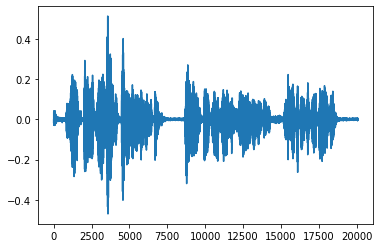

In [9]:
plt.plot(foo)

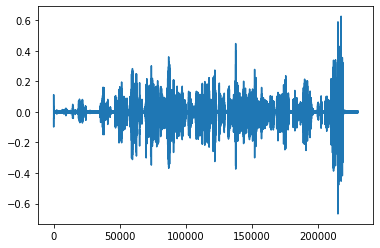

In [10]:
plt.plot(bar)

In [11]:
import IPython.display as ipd

In [12]:
ipd.Audio(bar, rate=sr)

In [13]:
start = 100
baz = bar[start:start+len(foo)]

In [14]:
len(baz), len(foo)

(20091, 20091)

In [15]:
((foo - baz)**2).sum()

74.12802

In [16]:
from tqdm import tqdm

mses = []
for start in tqdm(range(0, len(bar) - len(foo))):
    baz = bar[start:start+len(foo)]
    mse = ((foo - baz)**2).sum()
    mses.append((start, mse))

100%|██████████| 210062/210062 [00:06<00:00, 33787.95it/s]


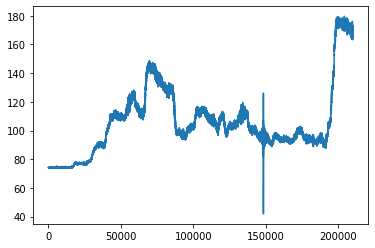

In [17]:
plt.plot([foo[1] for foo in mses])

In [18]:
qux = sorted(mses, key=lambda x: x[1])[0]

In [19]:
bar[qux[0]:qux[0]+len(foo)]

array([-0.03299164,  0.01151168,  0.01715231, ...,  0.00092352,
        0.00064066, -0.00185964], dtype=float32)

In [20]:
ipd.Audio(bar[qux[0]:qux[0]+len(foo)], rate=sr)

In [21]:
ipd.Audio(foo, rate=sr)

In [22]:
len(bar), qux

(230153, (148377, 41.85445))

In [38]:
start = qux[0] / len(bar)

end = (qux[0] + len(foo)) / len(bar)

In [39]:
start, end

(0.6446885332800355, 0.7319826376367026)

In [25]:
videos['train'][0]

'/home/tk/repos/erc/Datasets/IEMOCAP/raw-videos/train/Ses01F_impro01.avi'

In [26]:
import av
import numpy as np
container = av.open(videos['train'][0])

frames = []
for idx, frame in tqdm(enumerate(container.decode(video=0))):
    numpy_RGB = np.array(frame.to_image())
    frames.append(numpy_RGB)



3367it [00:22, 150.60it/s]


In [27]:
frames[0].shape

(480, 720, 3)

In [28]:
VID_WIDTH = frames[0].shape[1]
VID_HEIGHT = frames[0].shape[0]

In [29]:
len(frames), start, end

(3367, 0.6446885332800355, 0.7319826376367026)

In [30]:
import math

In [31]:
math.floor(len(frames) * start) , math.ceil(len(frames) * end)

(2170, 2465)

In [32]:
fps = (math.ceil(len(frames) * end) - math.floor(len(frames) * start)) / (len(foo) / sr)

In [33]:
round(fps)

30

In [34]:
save_full_path = 'foo.mp4'
container = av.open(save_full_path, mode='w')

stream = container.add_stream('mpeg4', rate=round(fps))
stream.width = VID_WIDTH
stream.height = VID_HEIGHT


OFFSET = -5

for frame in frames[math.floor(len(frames) * start) + OFFSET: math.ceil(len(frames) * end) + OFFSET]:
    frame_ = av.VideoFrame.from_ndarray(frame, format='rgb24')
    for packet in stream.encode(frame_):
        container.mux(packet)

        # Flush stream
for packet in stream.encode():
    container.mux(packet)

# Close the file
container.close()

In [35]:
audios['train'][11]

'/home/tk/repos/erc/Datasets/IEMOCAP/raw-audios/train/Ses01F_impro01/Ses01F_impro01_F011.wav'

In [36]:
!ffmpeg -i foo.mp4 -y -i /home/tk/repos/erc/Datasets/IEMOCAP/raw-audios/train/Ses01F_impro01/Ses01F_impro01_F011.wav -c:v copy -c:a aac output.mp4

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid